# Shared libraries and packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pysindy as ps

In [2]:
np.__version__

'1.26.4'

# "Final" Code

# Draft / Playground space below:

## Clayton Code

## Jackie Code

## Max Code

## Gaurav Code

## Richard Code

### Model Discovery from SIR Simulated Data

Explanation taken from "Model rediscovery from simulated data" [of original paper](https://www.nature.com/articles/s41598-020-63877-w#data-availability)
$$S_{t+1} = S_t + \nu - \beta (t) S_t I_t - \mu S_t,$$
$$I_{t+1} = I_t + \beta (t) S_t I_t - \gamma I_t - \mu I_t$$
$$R_{t+1} = R_t + \gamma I_t - \mu R_t$$

$S_t(I_t, R_t)$ is number of susceptible persons, $t$ is timestep, $\nu$ (resp. $\mu$) is the per capita birth (resp. death) rate per timestep, $\gamma$ is the per capita recovery rate per timestep, and $\beta(t)$ is the seasonally-varing transmission rate with form given by:

$$\beta(t) = \beta_0 (1 + \beta_1 \cos(2 \pi t/ T - \phi))$$ 

$T = 1$ year is period of oscillation, $\phi$ is a phase shift with seasonal behavior of the transmission rate. $t \approx$ one week for the paper

In [3]:
num_years = 2000
weeks_per_year = 52

# Initial conditions:
S_0 = 0.002
I_0 = 0.0
beta_0 = 0.8 / weeks_per_year
beta_1 = 0.025 / weeks_per_year
gamma = 0.1 / weeks_per_year # per capita recovery rate
phi = 0.                     # seasonal phase shift

mu = 5.4795*10e-5 / weeks_per_year # birth rate
nu = 5.4795*10e-5 / weeks_per_year # death rate

t = np.linspace(0, num_years, num_years * weeks_per_year)
beta = np.zeros(len(t))
S = np.zeros(len(t))
I = np.zeros(len(t))

np.random.seed(0)
noiseS = 10e-7 * np.random.randn(1,len(t)).squeeze()
noiseI = 10e-7 * np.random.randn(1,len(t)).squeeze()

S[0] = S_0
I[0] = I_0

for week in range(0,len(t)-1):
    beta[week] = beta_0 * (1.0 + beta_1 * np.cos(2.0*np.pi*float(week)/weeks_per_year - phi))
    S[week+1] = S[week] + nu - beta[week] * S[week] * I[week] - mu * S[week] + noiseS[week]
    I[week+1] = I[week] + beta[week] * S[week] * I[week] - gamma * I[week] - mu * I[week] + noiseI[week]

beta[len(t)-1] = beta_0 * (1.0 + beta_1 * np.cos(2.0*np.pi*float(t[-1]) - phi))

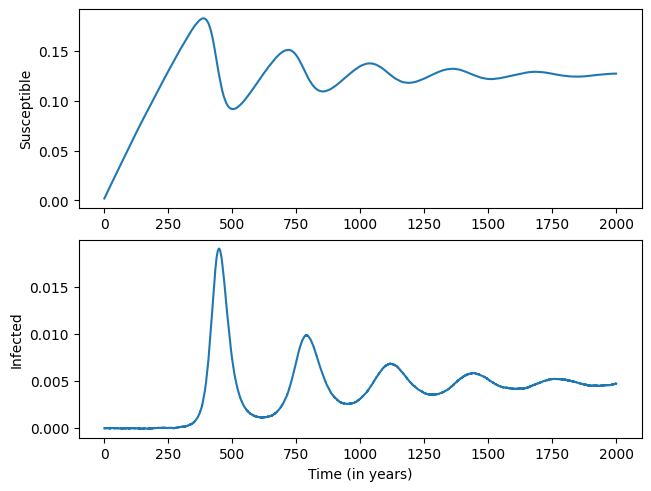

In [4]:
##############################
# Plot data
##############################

fig, ((ax1, ax2)) = plt.subplots(2, 1, layout="constrained")

ax1.plot(t,S)
ax1.set_ylabel('Susceptible')
ax1.set_title('')

ax2.plot(t,I)
ax2.set_xlabel('Time (in years)')
ax2.set_ylabel('Infected')
ax2.set_title('')
plt.show()

In [14]:
##############################
# Construct SINDy model for SIR
##############################

optimizer = ps.STLSQ(threshold=0.00001)

# Initialize custom SINDy library
library_functions = [
    lambda s: s,
    lambda i: i,
    lambda s: s * s,
    lambda s, i: s * i,
    lambda i: i * i,
    lambda beta: beta,
    lambda s, beta: beta * s,
    lambda i, beta: beta * i,
    lambda beta, s: beta * s * s,
    lambda beta, s, i: beta * s * i,
    lambda beta, i: beta * i * i
]

x_data = np.transpose(np.array([S,I,beta]))
lib = ps.CustomLibrary(library_functions=library_functions).fit(x_data)
# lib.transform(x_data)
lib.get_feature_names()
# sir_model = ps.SINDy(
#     feature_library=lib,
#     optimizer=optimizer,
#     feature_names=["S","I","beta"],
#     discrete_time=True
# )

# sir_model.fit(x_data, t=t)
# sir_model.print()

['f0(x0)',
 'f0(x1)',
 'f0(x2)',
 'f1(x0)',
 'f1(x1)',
 'f1(x2)',
 'f2(x0)',
 'f2(x1)',
 'f2(x2)',
 'f3(x0,x1)',
 'f3(x0,x2)',
 'f3(x1,x2)',
 'f4(x0)',
 'f4(x1)',
 'f4(x2)',
 'f5(x0)',
 'f5(x1)',
 'f5(x2)',
 'f6(x0,x1)',
 'f6(x0,x2)',
 'f6(x1,x2)',
 'f7(x0,x1)',
 'f7(x0,x2)',
 'f7(x1,x2)',
 'f8(x0,x1)',
 'f8(x0,x2)',
 'f8(x1,x2)',
 'f9(x0,x1,x2)',
 'f10(x0,x1)',
 'f10(x0,x2)',
 'f10(x1,x2)']

In [ ]:
##############################
# Construct SINDy model for SIR
##############################

feature_library = ps.PolynomialLibrary(degree=3)
optimizer = ps.STLSQ(threshold=0.00001)

# Initialize custom SINDy library
library_functions = [
    lambda s: s,
    lambda i: i,
    lambda s: s * s,
    lambda s, i: s * i,
    lambda i: i * i,
    lambda beta: beta,
    lambda s, beta: beta * s,
    lambda i, beta: beta * i,
    lambda beta, s: beta * s * s,
    lambda beta, s, i: beta * s * i,
    lambda beta, i: beta * i * i
]

lib = ps.CustomLibrary(library_functions=library_functions).fit(np.array([S,I,beta]))


Try to reproduce bifurcation diagram in [this article](https://www.mdpi.com/2227-7390/10/2/165) (see [this image](https://www.mdpi.com/mathematics/mathematics-10-00165/article_deploy/html/images/mathematics-10-00165-g002-550.jpg))

Note the form of the discrete SIR is a little bit different:
$$
\begin{cases}
S_{m+1} &= (1-p) S_m - \frac{\alpha}{N}I_m S_m + \beta (N - S_m)\\
I_{m+1} &= \frac{\alpha}{N}I_m S_m + (1 - \beta - \sigma ) I_m
\end{cases} 
$$

$\alpha=4, \beta=0.8, \sigma=0.1, p=0.005, N=100,$ and initial conditions $(S(0),I(0))=(70,30)$

In [30]:
# Initial conditions:
S_0 = 70.
I_0 = 30.


t = np.linspace(0, 10, 100)
S = np.zeros(len(t))
I = np.zeros(len(t))

alpha = 4.
beta = 0.8
sigma = 0.1
p = 0.005
N = 100

S[0] = S_0
I[0] = I_0

for week in range(0,len(t)-1):
    S[week+1] = (1. - p) * S[week] - (alpha / N) * I[week] * S[week] + beta * (N - S[week])
    I[week+1] = alpha / N * I[week] * S[week] + (1 - beta - sigma) * I[week]

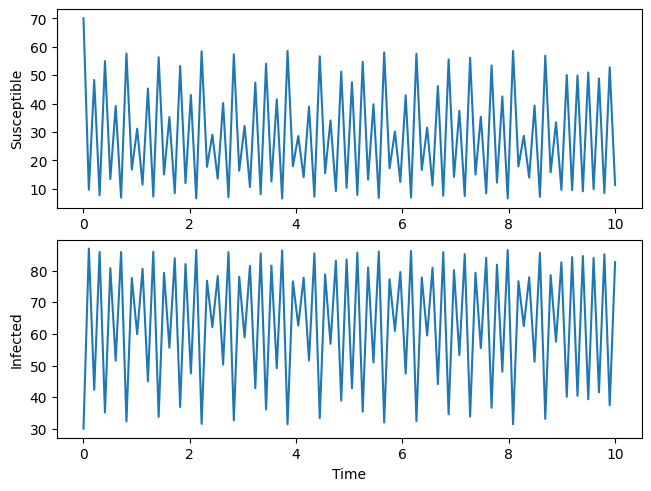

In [31]:
##############################
# Plot data
##############################

fig, ((ax1, ax2)) = plt.subplots(2, 1, layout="constrained")

ax1.plot(t,S)
ax1.set_ylabel('Susceptible')
ax1.set_title('')

ax2.plot(t,I)
ax2.set_xlabel('Time')
ax2.set_ylabel('Infected')
ax2.set_title('')
plt.show()

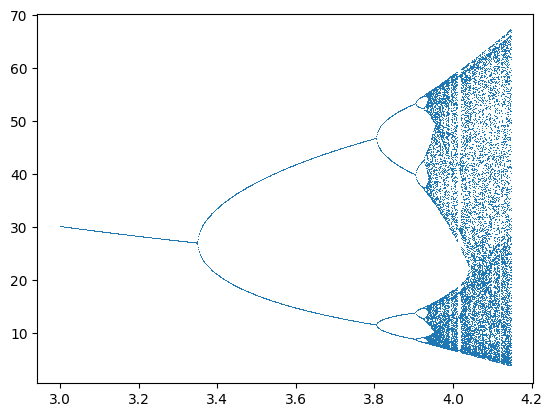

In [46]:
import numpy as np 
import matplotlib.pyplot as plt

# Initial conditions:
beta = 0.8
sigma = 0.1
p = 0.005
N = 100

def bifunc():
    alpha_val = []
    S_val = []
    alpha = np.linspace(3, 4.2, 1000)
    for a in alpha:
        S = 70
        I = 30
        for iterations in range(1000):
            S_temp = S
            I_temp = I
            S = (1. - p) * S_temp - (a / N) * I_temp * S_temp + beta * (N - S_temp)
            I = (a / N) * I_temp * S_temp + (1 - beta - sigma) * I_temp
            if S > 100000:
                break
            if I > 100000:
                break
            if iterations > 900:
                S_val.append(S)
                alpha_val.append(a)
    plt.plot(alpha_val, S_val, ls='', marker=',')
    plt.show()

bifunc()

### Model Discovery from Empirical Data

In [4]:
##############################
# Load data
# ref: https://github.com/jonathanhorrocks/SINDy-data/tree/master/Horrocks_Repo/data
##############################

import pandas as pd

chickenpox_data = pd.read_csv('data/OntarioChickenWeekly39_69.txt', sep="\t", header=None)
chickenpox_data.columns = ["week", "cases"]
rubella_data = pd.read_csv('data/OntarioRubellaWeekly39_69.txt', sep="\t", header=None)
rubella_data.columns = ["week", "cases"]

# Imports measles data matrix (stored as .mat file) - ref https://github.com/jonathanhorrocks/SINDy-data/blob/master/Horrocks_Repo/utils/susc_rec/SR_tester.m#L12C1-L13C54
# Columns: | Time | Cases | Population | Births |
import scipy.io
measles_data = pd.DataFrame(scipy.io.loadmat('data/mDataEW_N.mat')["mDataN"])
measles_data.columns = ["week", "cases", "population", "births"]

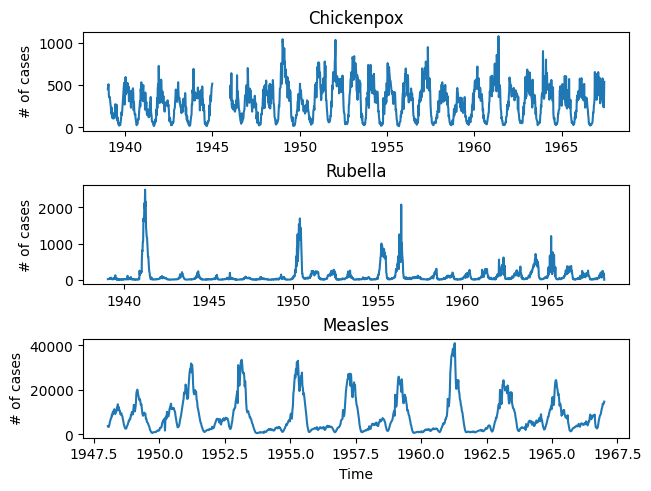

In [5]:
##############################
# Plot data
##############################

fig, ((ax1, ax2, ax3)) = plt.subplots(3, 1, layout="constrained")

ax1.plot(chickenpox_data["week"],chickenpox_data["cases"])
ax1.set_ylabel('# of cases')
ax1.set_title('Chickenpox')

ax2.plot(rubella_data["week"],rubella_data["cases"])
ax2.set_ylabel('# of cases')
ax2.set_title('Rubella')

ax3.plot(measles_data["week"],measles_data["cases"])
ax3.set_xlabel('Time')
ax3.set_ylabel('# of cases')
ax3.set_title('Measles')

plt.show()

From `Susceptible Reconstruction` section of [paper](https://www.nature.com/articles/s41598-020-63877-w.pdf):
$$Y_{t+1} = R_t - U_t Z_0 - (\alpha_{t+1} - \overline{\alpha} ) X_t + \alpha_{t+1} X_{t+1} + Z_{t+1} - u_{t+1}$$

where:
* $Y_t = \displaystyle{\sum_{i=1}^t B_{i-d,i-d+1}}$,
* $R_t = \displaystyle{\sum_{i=1}^t (\alpha_i - \overline{\alpha}) C_i}$,
* $U_t = \displaystyle{\sum_{i=1}^t u_i}$,
* $X_t = \displaystyle{\sum_{i=1}^t C_{i,i+1}}$,
* $B_{t,t+1}$ are the number of new births in week $t$
* $C_{t,t+1}$ are the number of new cases in week $t$
* $Z_t$ is the deviation from the mean Susceptible cases at week $t$, i.e. $S_t = \overline{S} + Z_t$,
* $\alpha_t$ is the rate at which cases are reported at week $t$,
* $u_t$ is the additive noise at week $t$ (assumed to be random Normal - $E(u) = 0, V(u) = \sigma_u^2$)


In [ ]:
####
# TODO: Build "Susceptible" Estimation 
####

Some data cleanup appears to be necessary in some of the datasets...

In [6]:
# Identify rows that are NaN in rubella dataset
print("The following rows have a value of NaN:")
print(rubella_data[rubella_data["cases"].isnull()])

# Scrub the NaN rows and create a new rubella_data_nonan set
print("Linearly interpolating NaN rows...")
rubella_data_nonan = rubella_data.copy()
rubella_data_nonan["cases"] = rubella_data["cases"].interpolate(method='linear', limit_direction='forward', axis=0)

print("The following rows of rubella_data_nonan now have a value of NaN (should be empty):")
print(rubella_data_nonan[rubella_data_nonan["cases"].isnull()],"\n")

# Remove the rows where "week" is not montonically inccreasing:
rubella_data_nonan['increasing'] = np.where(rubella_data_nonan['week'] > rubella_data_nonan['week'].shift(), 1, 0)
rubella_data_nonan.loc[0,'increasing'] = 1
print("The following rows have a non-increasing value for 'weeks':")
print(rubella_data_nonan[rubella_data_nonan['increasing'] == False])
print(rubella_data_nonan[197:201],"\n")

rubella_data_nonan_inc = rubella_data_nonan.copy()

print("Swapping non-increasing data values...")
rubella_data_nonan_inc.iloc[[198]] = rubella_data_nonan.iloc[[199]]
rubella_data_nonan_inc.iloc[[199]] = rubella_data_nonan.iloc[[198]]

rubella_data_nonan_inc['increasing'] = np.where(rubella_data_nonan_inc['week'] > rubella_data_nonan_inc['week'].shift(), 1, 0)
rubella_data_nonan_inc.loc[0,'increasing'] = 1
print("The following rows have a non-increasing value for 'weeks' (should be empty):")
print(rubella_data_nonan_inc[rubella_data_nonan_inc['increasing'] == False])

The following rows have a value of NaN:
            week  cases
29   1939.574949    NaN
397  1946.627652    NaN
712  1952.664613    NaN
Linearly interpolating NaN rows...
The following rows of rubella_data_nonan now have a value of NaN (should be empty):
Empty DataFrame
Columns: [week, cases]
Index: [] 

The following rows have a non-increasing value for 'weeks':
            week  cases  increasing
199  1942.805613    8.0           0
            week  cases  increasing
197  1942.794661    8.0           1
198  1942.813826    5.0           1
199  1942.805613    8.0           0
200  1942.852156    7.0           1 

Swapping non-increasing data values...
The following rows have a non-increasing value for 'weeks' (should be empty):
Empty DataFrame
Columns: [week, cases, increasing]
Index: []


In [204]:
##############################
# Construct SINDy model - NOTE: this does not appear to be functional; probably need to (1) denoise and/or (2) add Susceptible data
##############################

differentiation_method = ps.FiniteDifference(order=1)
feature_library = ps.PolynomialLibrary(degree=2)
optimizer = ps.STLSQ(threshold=0.3)

rubella_model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["i"],
    discrete_time=True
)

rubella_model.fit(rubella_data_nonan_inc["cases"].values, t=rubella_data_nonan_inc["week"].values)
rubella_model.print()

(i)[k+1] = 11.454 1 + 0.901 i[k]


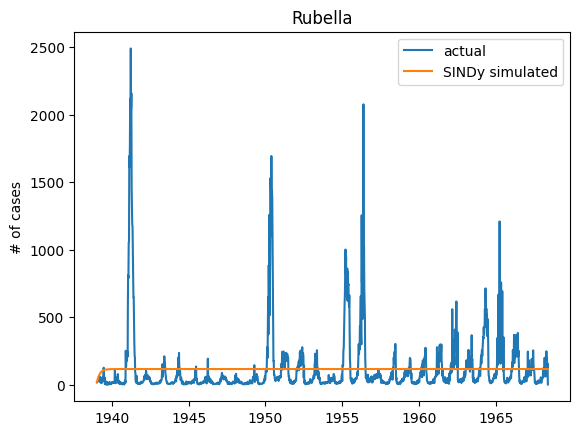

In [212]:
##############################
# Simulate using SINDy model
##############################

init_value = [rubella_data_nonan_inc["cases"][0]]
# sim = rubella_model.simulate(init_value, t=rubella_data_nonan_inc["week"].values)
sim = rubella_model.simulate(init_value, t=len(rubella_data_nonan_inc))

##############################
# Plot data
##############################

fig, ((ax)) = plt.subplots(1, 1)

ax.plot(rubella_data_nonan_inc["week"], rubella_data_nonan_inc["cases"], label="actual")
ax.plot(rubella_data_nonan_inc["week"], sim, label="SINDy simulated")
ax.set_ylabel('# of cases')
ax.set_title('Rubella')
ax.legend()

plt.show()